In [2]:
import pandas as pd
import numpy as np

from sklearn import ensemble, linear_model
from sklearn.mixture import GaussianMixture
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

- define function for data split

In [16]:
np.random.seed(2021)

def split_train_test(data_pos, data_neg, test_ratio):
    shuffled_indices_pos = np.random.permutation(len(data_pos))
    test_set_size_pos = int(len(data_pos) * test_ratio)
    test_indices_pos = np.array(shuffled_indices_pos[:test_set_size_pos])
    train_indices_pos = np.array(shuffled_indices_pos[test_set_size_pos:])
    
    shuffled_indices_neg = np.random.permutation(len(data_neg))
    test_set_size_neg = int(len(data_neg) * test_ratio)
    test_indices_neg = np.array(shuffled_indices_neg[:test_set_size_neg])
    train_indices_neg = np.array(shuffled_indices_neg[test_set_size_neg:])
    
    return np.concatenate((data_pos[train_indices_pos], data_neg[train_indices_neg])), np.concatenate((data_pos[test_indices_pos], data_neg[test_indices_neg]))

- define functions for plot graph

In [50]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.xlabel("Threshold", fontsize=12)
    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.legend()
    
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, linewidth=2, label="Precision_vs_Recall")
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
    
def plot_fbeta_vs_threshold(fbeta, thresholds):
    plt.xlabel("Threshold", fontsize=12)
    fbeta_max = np.max(fbeta)
    thres_fbeta_max = thresholds[fbeta == fbeta_max][0]
    plt.axis([0, 1, 0, 1])
    plt.plot(thresholds, fbeta, label="fbeta")
    plt.plot([thres_fbeta_max, thres_fbeta_max], [0., fbeta_max], "r:")
    plt.plot([-2, thres_fbeta_max], [fbeta_max, fbeta_max], "r:")
    plt.plot([thres_fbeta_max], [fbeta_max], "ro")
    plt.legend()
    
    
def plot_roc_curve(fpr, tpr):
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.plot(fpr, tpr, label="roc_curve")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    

- define functions for evaluations

In [89]:
def evaluations(y_pred_proba, X, y, beta, graph=False):
    print("Now going to find threshold maximize fbeta...")
    # compute fbeta under different thresholds
    thresholds_test = np.arange(0, 1, 0.05) # probability between 0 to 1
    fbetas = np.zeros((len(thresholds_test)))
    for i in range(len(thresholds_test)):
        y_pred_test = (y_pred_proba >= thresholds_test[i])
        fbetas[i] = fbeta_score(y, y_pred_test, beta=beta, average='macro')
    # threshold maximize fbeta 
    fbeta_max = np.max(fbetas)
    thres_fbeta_max = thresholds_test[fbetas == fbeta_max][0]
    print("Finished, now going to get precision and recall...")
    # pricision & recall 
    y_pred = (y_pred_proba >= thres_fbeta_max)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    print("Finished, now going to get ROC AUC...")
    # ROC AUC 
    roc_auc = roc_auc_score(y, y_pred_proba)

    # results
    res = list(map(lambda x: round(x, 4),[precision, recall, fbeta_max, roc_auc]))
    
    if graph:
        # plot precision_recall_vs_threshold
        plt.subplot(321)
        precisions, recalls, thresholds_pr = precision_recall_curve(y, y_pred_proba)
        plot_precision_recall_vs_threshold(precisions, recalls, thresholds_pr)
        # plot fbeta_vs_threshold
        plt.subplot(322)
        plot_fbeta_vs_threshold(fbetas, thresholds_test)
        # plot roc_auc_curve
        plt.subplot(212)
        fpr, tpr, thresholds_ = roc_curve(y, y_pred_proba)
        plot_roc_curve(fpr, tpr)
        
    print("Done!") 
    return res


def fit_and_evaluations(model, X_train, y_train, X, y, beta, graph=False):
    # fit model
    model.fit(X_train, y_train)
    print("Finish fit model, now going to predict proba...")
    # predict_proba get probability, use for adjust threshold
    y_pred_proba_ = model.predict_proba(X)
    y_pred_proba = y_pred_proba_[:, 1]
    print("Finished. ", end=' ')
    res = evaluations(y_pred_proba, X, y, beta, graph=graph)
    return res
    

def GMM_classifier_evaluations(cluster_n, max_iter, n_init, X_train, y_train, X, y, models, beta, graph=False):
    # train GMM
    gm = GaussianMixture(n_components=cluster_n, max_iter=max_iter, n_init=n_init)
    print("GaussianMixtureModel created, now going to fit model...")
    gm.fit(X_train)
    print("Finished, now going to cluster train data...")
    gmm_pred_proba_train = gm.predict_proba(X_train)
    cluster_cls_train = gmm_pred_proba_train > (1./cluster_n) # clusters to train classifier
    # test data
    print("Finished, now going to cluster test data...")
    gmm_pred_proba = gm.predict_proba(X)
    cluster_cls = gmm_pred_proba > (1./cluster_n) # clusters to test
    print("Finished, now going to train classifiers and get proba...")
    # compute proba base on formula
    res_all = {}
    for model in models:
        print(f"******{model}******")
        y_pred_proba = np.zeros(len(X))
        for k in range(cluster_n):
            if np.all(y_train[cluster_cls_train[:,k]]==1) or np.all(y_train[cluster_cls_train[:,k]]==0):
                print(f"Same Labels in Cluster{k}, skip.")
                continue
            # train classifier
            model.fit(X_train[cluster_cls_train[:,k]], y_train[cluster_cls_train[:,k]])
            # test data
            pred_proba_ = model.predict_proba(X[cluster_cls[:, k]])
            # compute proba
            ind = 0
            for i in range(len(X)):
                if cluster_cls[i, k]:
                    y_pred_proba[i] += gmm_pred_proba[i, k] * pred_proba_[ind, 1]
                    ind += 1
            print(f"Cluster{k} finished!")
        res = evaluations(y_pred_proba, X, y, beta, graph=graph)
        res_all[f"{model}"] = res
    return res_all


### Data Pre-Processing

In [ ]:
loanStats = pd.read_csv('LoanStats_2016Q4.csv', skiprows = 1)
rejectStats = pd.read_csv('RejectStats_2016Q4.csv', skiprows = 1)

/Users/mengyuan/opt/anaconda3/envs/oplex/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (0,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Drop last two rows

In [4]:
loanStats = loanStats.drop(loanStats.index[-2:])

Drop first two columns since they are empty

In [5]:
loanStats = loanStats.drop(['id', 'member_id'], axis = 1)

There are only 9 columns in reject data, let's try to match loan data with reject data:<br/>
* 'loan_amnt' in loanStats should match with 'Amount Requested' in rejectStats.
* 'issue_d' in loanStats is the issue date, it should be later than 'Application Date' in rejectStats, let's ignore this pair for now.
* 'title' in loanStats should match with 'Loan Title' in rejectStats. However, we need to deal with upper/lower case and space/underscore issues.
* There is no column in loanStats matches with 'Risk_Score' in rejectStats, would be very useful if there was one.
* 'dti' in loanStats matches with 'Debt-To-Income Ratio' in rejectStats.
* 'zip_code' and 'addr_state' in loanStats match with 'Zip Code' and 'State' in rejectStats respectively. Zip codes are only available in first 3 digits, and we might need to get external data for the demographics about the zip code.
* 'emp_length' in loanStats matches with 'Employment Length' in rejectStats.
* 'policy_code' in loanStats matches with 'Policy Code' in rejectStats.

However, policy code is useless since it carries different meaning in the two datasets, so we should ignore this pair of columns.<br/>
Let's now build two new dataframes, and keep their columns consistent.

In [6]:
approved = pd.DataFrame()
rejected = pd.DataFrame()

Copy values from 'loan_amnt' and 'Amount Requested' directly to the new dataframes

In [7]:
approved['amount'] = loanStats['loan_amnt']
rejected['amount'] = rejectStats['Amount Requested']

Using lambda functions to convert strings, first make all characters lower cases, and split them by space, then join them using '\_'. While joining, remove words like 'and', 'expenses', 'financing', 'loan', 'refinancing', as these words are not important in reasons for loans. To further consolidate the reasons, we merge 'housing' to 'home\_buying', 'moving' to 'moving\_relocation', 'renewable\_energy' to 'green', and 'small\_business' to 'business'.

In [8]:
stop_words = ['and', 'expenses', 'financing', 'loan', 'refinancing']
approved['reason'] = loanStats['title'].apply(lambda x: 'other' if type(x) != str else '_'.join([i for i in x.lower().split() if i not in stop_words]))
rejected['reason'] = rejectStats['Loan Title'].apply(lambda x: 'other' if type(x) != str else '_'.join([i for i in x.lower().split() if i not in stop_words]))
convert = {'house': 'home_buying', 'moving': 'moving_relocation', 'renewable_energy': 'green', 'small_business': 'business'}
rejected['reason'] = rejected['reason'].apply(lambda x: convert[x] if x in convert else x)

Copy values from 'dti' and 'Debt-To-Income Ratio', however, to identify Not-a-Number floats, we test x == x, in it's a NaN, we set it to the maximum in the dataset.

In [9]:
approved['debt_to_income'] = loanStats['dti'].apply(lambda x: max(0.0, min(x / 100, 1.0)) if x == x else 1.0)
rejected['debt_to_income'] = rejectStats['Debt-To-Income Ratio'].apply(lambda x: max(0.0, min(float(x[:-1]) / 100, 1.0)))

Keep the first 3 digits of the zip codes since the last 2 digits are masked, however, it is unnecessary to convert them to numbers.

In [10]:
approved['zip3'] = loanStats['zip_code'].apply(lambda x: x[:3] if type(x) == str else 'N/A')
rejected['zip3'] = rejectStats['Zip Code'].apply(lambda x: x[:3] if type(x) == str else 'N/A')
approved['state'] = loanStats['addr_state']
rejected['state'] = rejectStats['State']

Convert the employment length to numerical values, if it is not specified, or less than a year, we take them as 0.

In [11]:
approved['employ_length'] = loanStats['emp_length'].apply(lambda x: 0 if type(x) != str or x[:3] == '< 1' else int(x[:2]))
rejected['employ_length'] = rejectStats['Employment Length'].apply(lambda x: 0 if type(x) != str or x[:3] == '< 1' else int(x[:2]))

The column 'reason' is now the only nominal column, we may use function get\_dummies, drop 'other' is recommended since 'reason\_=\_other' is fuzzy, and should be expressed by 0 in all other reason columns.

In [12]:
approved = pd.concat([approved, pd.get_dummies(approved['reason'], prefix = 'reason', prefix_sep = '_=_').drop('reason_=_other', axis = 1)], axis = 1).drop('reason', axis = 1)
rejected = pd.concat([rejected, pd.get_dummies(rejected['reason'], prefix = 'reason', prefix_sep = '_=_').drop('reason_=_other', axis = 1)], axis = 1).drop('reason', axis = 1)

Add the response column to the two dataframes.

In [13]:
approved['approved'] = 1
rejected['approved'] = 0

Convert the two dataframes to numpy arrays.

In [14]:
data_pos = approved.drop(['zip3', 'state'], axis = 1).values
data_neg = rejected.drop(['zip3', 'state'], axis = 1).values

In [169]:
test_ratio = 0.2
train_data, test_data = split_train_test(data_pos, data_neg, test_ratio)

In [170]:
X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

### [Question 1] Build Logistic Regression Models and Naive Bayes Models

Build the two basic classification models

In [171]:
beta = 0.5
reason_of_beta = """Approve applicants who should be rejected means at the risk of lossing principal,
while reject applicants who can be approved means the loss of interest of principal.
The cost of lossing interest gain is far less than lossing principal, 
thus Precision is supposed to be more important in this scenario. 
Choose Beta equals to 0.5 give more weight to Precision."""

- Logistic Regression Model

In [172]:
C = 1
logistic_model = linear_model.LogisticRegression(C=C)

Finish fit model, now going to predict proba...
Finished.  Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!


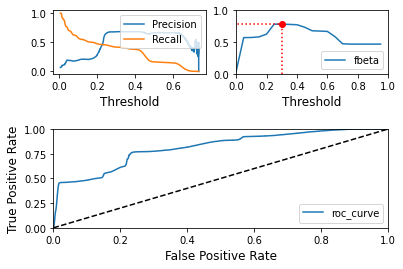

In [173]:
logistic_model_res = fit_and_evaluations(logistic_model, X_train, y_train, X_test, y_test, beta=beta, graph=True)

- Naive Bayes Models

In [175]:
bayes_model = naive_bayes.GaussianNB()

Finish fit model, now going to predict proba...
Finished.  Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!


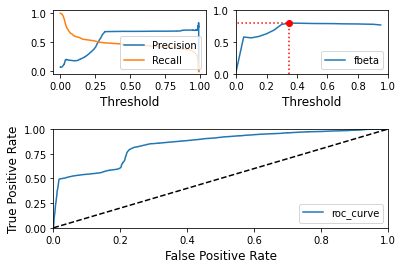

In [176]:
bayes_model_res = fit_and_evaluations(bayes_model, X_train, y_train, X_test, y_test, beta=beta, graph=True)

#### Results

In [178]:
# results
print(f"Choose beta = {beta}")
print("Reason: ", reason_of_beta)

info_dict = {f"Logistic Regression with C = {C}": np.append([beta], logistic_model_res),
            "Naive Bayes": np.append([beta],bayes_model_res)}

res_pd = pd.DataFrame(info_dict, index = ["Chosen beta", "Precision", "Recall", "$F_{beta}$", "AUC under ROC"])
res_pd

Choose beta = 0.5
Reason:  Approve applicants who should be rejected means at the risk of lossing principal,
while reject applicants who can be approved means the loss of interest of principal.
The cost of lossing interest gain is far less than lossing principal, 
thus Precision is supposed to be more important in this scenario. 
Choose Beta equals to 0.5 give more weight to Precision.


,Logistic Regression with C = 1,Naive Bayes
Chosen beta,0.5000,0.5000
Precision,0.6817,0.6855
Recall,0.4180,0.4874
$F_{beta}$,0.7845,0.8005
AUC under ROC,0.8132,0.8438


### [Question 2] Build Classification Models over GMM

Build GMM models + classification models

In [40]:
C = 1
beta = 0.5
logit = linear_model.LogisticRegression(C=C)
bayes = naive_bayes.GaussianNB()
base_models = [logit, bayes]

- 5 Clusters & Classifiers

In [90]:
max_iter_5 = 30
n_init_5 = 10
cluster_n = 5
clusters_5_res = GMM_classifier_evaluations(cluster_n, max_iter_5, n_init_5, 
                                            X_train, y_train, X_test, y_test, base_models, beta, graph=False)

GaussianMixtureModel created, now going to fit model...
Finished, now going to cluster train data...
Finished, now going to cluster test data...
Finished, now going to train classifiers and get proba...
******LogisticRegression(C=1)******
Cluster0 finished!
Cluster1 finished!
Cluster2 finished!
Cluster3 finished!
Cluster4 finished!
Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!
******GaussianNB()******
Cluster0 finished!
Cluster1 finished!
Cluster2 finished!
Cluster3 finished!
Cluster4 finished!
Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!


In [91]:
clusters_5_res

{'LogisticRegression(C=1)': [0.6975, 0.3858, 0.7814, 0.8433],
 'GaussianNB()': [0.6887, 0.4749, 0.7991, 0.8559]}

- 10 Clusters & Classifiers

In [224]:
max_iter_10 = 30
n_init_10 = 30
cluster_n = 10
clusters_10_res = GMM_classifier_evaluations(cluster_n, max_iter_10, n_init_10, 
                                             X_train, y_train, X_test, y_test, base_models, beta, graph=False)

GaussianMixtureModel created, now going to fit model...
Finished, now going to cluster train data...
Finished, now going to cluster test data...
Finished, now going to train classifiers and get proba...
******LogisticRegression(C=1)******
Cluster0 finished!
Cluster1 finished!
Same Labels in Cluster2, skip.
Cluster3 finished!
Cluster4 finished!
Cluster5 finished!
Same Labels in Cluster6, skip.
Same Labels in Cluster7, skip.
Cluster8 finished!
Cluster9 finished!
Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!
******GaussianNB()******
Cluster0 finished!
Cluster1 finished!
Same Labels in Cluster2, skip.
Cluster3 finished!
Cluster4 finished!
Cluster5 finished!
Same Labels in Cluster6, skip.
Same Labels in Cluster7, skip.
Cluster8 finished!
Cluster9 finished!
Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!


In [226]:
clusters_10_res

{'LogisticRegression(C=1)': [0.6877, 0.4683, 0.7974, 0.8564],
 'GaussianNB()': [0.6877, 0.4653, 0.7968, 0.8565]}

- 20 Clusters & Classifiers

In [228]:
# 20 Clusters & Classifiers
max_iter_20 = 50
n_init_20 = 50
cluster_n = 20
clusters_20_res = GMM_classifier_evaluations(cluster_n, max_iter_20, n_init_20, 
                                             X_train, y_train, X_test, y_test, base_models, beta, graph=False)

GaussianMixtureModel created, now going to fit model...
Finished, now going to cluster train data...
Finished, now going to cluster test data...
Finished, now going to train classifiers and get proba...
******LogisticRegression(C=1)******
Cluster0 finished!
Cluster1 finished!
Same Labels in Cluster2, skip.
Same Labels in Cluster3, skip.
Cluster4 finished!
Cluster5 finished!
Cluster6 finished!
Same Labels in Cluster7, skip.
Same Labels in Cluster8, skip.
Cluster9 finished!
Cluster10 finished!
Cluster11 finished!
Cluster12 finished!
Same Labels in Cluster13, skip.
Cluster14 finished!
Same Labels in Cluster15, skip.
Cluster16 finished!
Cluster17 finished!
Cluster18 finished!
Cluster19 finished!
Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!
******GaussianNB()******
Cluster0 finished!
Cluster1 finished!
Same Labels in Cluster2, skip.
Same Labels in Cluster3, skip.
Cluster4 finished!
Cluster5 finis

In [229]:
clusters_20_res

{'LogisticRegression(C=1)': [0.6997, 0.3845, 0.7817, 0.8519],
 'GaussianNB()': [0.6857, 0.4585, 0.7948, 0.8627]}

#### Results

In [230]:
# results
info2_dict = {f"Logistic Regression with C = {C}": np.array([c["LogisticRegression(C=1)"] for c in [clusters_5_res,clusters_10_res,clusters_20_res]]).flatten(),
            "Naive Bayes": np.array([c["GaussianNB()"] for c in [clusters_5_res,clusters_10_res,clusters_20_res]]).flatten()}

res_pd = pd.DataFrame(info2_dict)
res_pd["Cluster_n"] = np.array([[f"{i} clusters"]*4 for i in [5, 10, 20]]).flatten()
res_pd["Evaluations"] = ["Precision", "Recall", "$F_{beta}$", "AUC under ROC"]*3

res_pd.set_index(['Cluster_n', "Evaluations"], inplace=True)
res_pd.index.names = [' ', ' ']
res_pd

Logistic Regression with C = 1  Naive Bayes
                                                                      
5 clusters  Precision                              0.6975       0.6887
            Recall                                 0.3858       0.4749
            $F_{beta}$                             0.7814       0.7991
            AUC under ROC                          0.8433       0.8559
10 clusters Precision                              0.6877       0.6877
            Recall                                 0.4683       0.4653
            $F_{beta}$                             0.7974       0.7968
            AUC under ROC                          0.8564       0.8565
20 clusters Precision                              0.6997       0.6857
            Recall                                 0.3845       0.4585
            $F_{beta}$                             0.7817       0.7948
            AUC under ROC                          0.8519       0.8627

### [Question 3] Build Ensemble Models

Build your Ensemble Models for this part

- bagging

In [198]:
C = 1
bag_cls = ensemble.BaggingClassifier(RandomForestClassifier(),
                                    n_estimators=10, max_samples=100, bootstrap=True, n_jobs=-1,
                                    random_state=2021)

Finish fit model, now going to predict proba...
Finished.  Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!


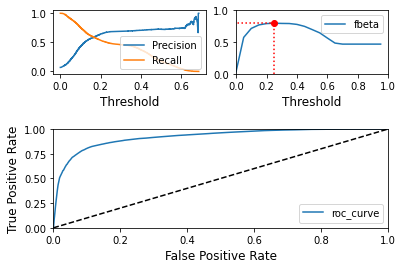

In [199]:
bag_cls_res = fit_and_evaluations(bag_cls, X_train, y_train, X_test, y_test, beta=beta, graph=True)

- boosting

In [196]:
C = 1
bos_cls = ensemble.AdaBoostClassifier(RandomForestClassifier(n_estimators=30),
                                    n_estimators=5, learning_rate=0.8, algorithm="SAMME.R",
                                    random_state=2021)

Finish fit model, now going to predict proba...
Finished.  Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!


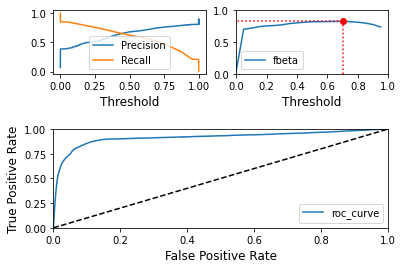

In [181]:
bos_cls_res = fit_and_evaluations(bos_cls, X_train, y_train, X_test, y_test, beta=beta, graph=True)

- stacking

In [132]:
C = 1
stk_cls = ensemble.StackingClassifier([('rf', RandomForestClassifier()),
                                      ('nb', naive_bayes.GaussianNB()),
                                      ('lg', linear_model.LogisticRegression(C=C))],
                                      final_estimator = linear_model.LogisticRegression(C=C),
                                      cv=3, stack_method="predict_proba", n_jobs=-1)

Finish fit model, now going to predict proba...
Finished.  Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!


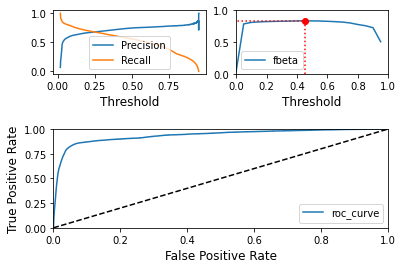

In [126]:
stk_cls_res = fit_and_evaluations(stk_cls, X_train, y_train, X_test, y_test, beta=beta, graph=True)

#### Results

In [200]:
info3_dict = {"Bagging": np.append(["RandomForestClassifier", "n_estimators=10, max_samples=100, bootstrap=True, n_jobs=-1,\
                                    random_state=2021"], bag_cls_res),
             "Boosting": np.append(["RandomForestClassifier(n_estimators=30)", "n_estimators=5, learning_rate=0.8, algorithm='SAMME.R',\
                                    random_state=2021"], bos_cls_res),
             "Stacking": np.append(["RandomForestClassifier, GaussianNB, LogisticRegression",
                                      "final_estimator = linear_model.LogisticRegression(C=1), \
                                      cv=3, stack_method='predict_proba', n_jobs=-1"], stk_cls_res)}

inx = ["Base classifiers", "Parameter settings", "Precision", "Recall", "$F_{beta}$", "AUC"]

In [201]:
# result
pd.set_option('display.max_colwidth', None)
res3_pd = pd.DataFrame(info3_dict, index = inx)
res3_pd

,Bagging,Boosting,Stacking
Base classifiers,RandomForestClassifier,RandomForestClassifier(n_estimators=30),"RandomForestClassifier, GaussianNB, LogisticRegression"
Parameter settings,"n_estimators=10, max_samples=100, bootstrap=True, n_jobs=-1, random_state=2021","n_estimators=5, learning_rate=0.8, algorithm='SAMME.R', random_state=2021","final_estimator = linear_model.LogisticRegression(C=C), cv=3, stack_method='predict_proba', n_jobs=-1"
Precision,0.6842,0.7483,0.7327
Recall,0.4822,0.5184,0.582
$F_{beta}$,0.799,0.8285,0.8346
AUC,0.9196,0.914,0.9234


In [ ]:
comments_3 = """From the table above, these three models' performance are good. \
Stacking depict best performance among these three models in terms of AUC.
Boosting takes more time to trian with the same parameter settings. 
Computing power's limitations make training boosting can only on low parameters, \
which can shorten the training time, but Boosting's best performance can't be presented. 
When reducing bagging N_ESTIMATORS parameter number, the result is not good as boosting.
Boosting is supposed to be a better choice without the limitation of computing power."""

### [Question 4] Build Ensemble Models with External Data

getting external data<br/>
https://www.irs.gov/pub/irs-soi/16zpallagi.csv<br/>
more details:<br/>
https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2016-zip-code-data-soi

In [202]:
f = open('16zpallagi.csv', 'r')
f.readline()
count = {}
for l in f.readlines():
    s = l.split(',')
    if s[2] == '0':
        count[s[1], int(s[3])] = int(s[4])
    else:
        count['%05d' % int(s[2]), int(s[3])] = int(s[4])
agg_count = {}
for k, v in count.items():
    if k[0][:3] not in agg_count:
        agg_count[k[0][:3]] = [0] * 7
    agg_count[k[0][:3]][k[1]] += v
f.close()

In [203]:
# Assume incomes bracketed are [12500, 37500, 62500, 87500, 150000, 400000]
# 1 = $1 under $25,000
# 2 = $25,000 under $50,000
# 3 = $50,000 under $75,000
# 4 = $75,000 under $100,000
# 5 = $100,000 under $200,000
# 6 = $200,000 or more

bracket_income = [0, 12500, 37500, 62500, 87500, 150000, 400000]
estimated_zip_income = {}
for k, v in agg_count.items():
    sumn, sumd = 0, 0
    for i in range(1, 7):
        sumn += bracket_income[i] * v[i]
        sumd += v[i]
    estimated_zip_income[k] = sumn / sumd

In [204]:
approved.insert(4, 'estimated_income', approved[['zip3', 'state']].apply(lambda x: estimated_zip_income[x[0]] if x[0] in estimated_zip_income else estimated_zip_income[x[1]] if x[1] in estimated_zip_income else 0, axis = 1))
rejected.insert(4, 'estimated_income', rejected[['zip3', 'state']].apply(lambda x: estimated_zip_income[x[0]] if x[0] in estimated_zip_income else estimated_zip_income[x[1]] if x[1] in estimated_zip_income else 0, axis = 1))
data_pos = approved.drop(['zip3', 'state'], axis = 1).values
data_neg = rejected.drop(['zip3', 'state'], axis = 1).values

In [205]:
test_ratio = 0.2
train_data_new, test_data_new = split_train_test(data_pos, data_neg, test_ratio)

In [206]:
X_train_new, y_train_new = train_data_new[:, :-1], train_data_new[:, -1]
X_test_new, y_test_new = test_data_new[:, :-1], test_data_new[:, -1]

- bagging

In [214]:
C = 1
bag_cls4 = ensemble.BaggingClassifier(RandomForestClassifier(),
                                    n_estimators=10, max_samples=100, bootstrap=True, n_jobs=-1,
                                    random_state=2021)

Finish fit model, now going to predict proba...
Finished.  Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!


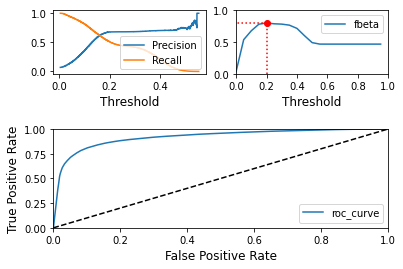

In [215]:
bag_cls_res4 = fit_and_evaluations(bag_cls4, X_train_new, y_train_new, X_test_new, y_test_new, 
                                   beta=beta, graph=True)

- boosting

In [216]:
C = 1
bos_cls4 = ensemble.AdaBoostClassifier(RandomForestClassifier(n_estimators=30),
                                    n_estimators=5, learning_rate=0.8, algorithm="SAMME.R",
                                    random_state=2021)

Finish fit model, now going to predict proba...
Finished.  Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!


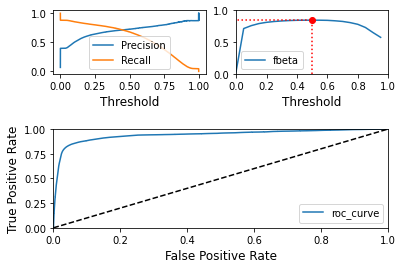

In [217]:
bos_cls_res4 = fit_and_evaluations(bos_cls4, X_train_new, y_train_new, X_test_new, y_test_new, 
                                   beta=beta, graph=True)

- stacking

In [218]:
C = 1
stk_cls4 = ensemble.StackingClassifier([('rf', RandomForestClassifier()),
                                      ('nb', naive_bayes.GaussianNB()),
                                      ('lg', linear_model.LogisticRegression(C=C))],
                                      final_estimator = linear_model.LogisticRegression(C=C),
                                      cv=3, stack_method="predict_proba", n_jobs=-1)

Finish fit model, now going to predict proba...
Finished.  Now going to find threshold maximize fbeta...
Finished, now going to get precision and recall...
Finished, now going to get ROC AUC...
Done!


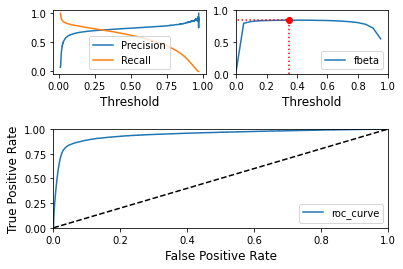

In [219]:
stk_cls_res4 = fit_and_evaluations(stk_cls4, X_train_new, y_train_new, X_test_new, y_test_new, 
                                   beta=beta, graph=True)

#### Results

In [222]:
info4_dict = {"Bagging": np.append(["RandomForestClassifier", "n_estimators=10, max_samples=100, bootstrap=True, n_jobs=-1,\
                                    random_state=2021"], bag_cls_res4),
             "Boosting": np.append(["RandomForestClassifier(n_estimators=30)", "n_estimators=5, learning_rate=0.8, algorithm='SAMME.R',\
                                    random_state=2021"], bos_cls_res4),
             "Stacking": np.append(["RandomForestClassifier, GaussianNB, LogisticRegression",
                                      "final_estimator = linear_model.LogisticRegression(C=1), \
                                      cv=3, stack_method='predict_proba', n_jobs=-1"], stk_cls_res4)}

inx = ["Base classifiers", "Parameter settings", "Precision", "Recall", "$F_{beta}$", "AUC"]

In [223]:
# result
pd.set_option('display.max_colwidth', None)
res4_pd = pd.DataFrame(info4_dict, index = inx)
res4_pd

,Bagging,Boosting,Stacking
Base classifiers,RandomForestClassifier,RandomForestClassifier(n_estimators=30),"RandomForestClassifier, GaussianNB, LogisticRegression"
Parameter settings,"n_estimators=10, max_samples=100, bootstrap=True, n_jobs=-1, random_state=2021","n_estimators=5, learning_rate=0.8, algorithm='SAMME.R', random_state=2021","final_estimator = linear_model.LogisticRegression(C=1), cv=3, stack_method='predict_proba', n_jobs=-1"
Precision,0.6782,0.7258,0.721
Recall,0.5123,0.679,0.6939
$F_{beta}$,0.8025,0.8467,0.8467
AUC,0.9184,0.9405,0.9443


In [169]:
comments_4 = """With new add data, Boosting and Stacking perform better than before with same parameters.
Boosting perform well even with lower parameter set. 
However, Bagging's performance seems not improve with new add data.""" 